In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/Users/datnguyen/Work/others/')

from utils.db_utils import df_from_snowflake
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

platforms=['android', 'ios']

In [2]:
query = """
select
        date_trunc('day', date) dt,
        os_name platform,
        iff(os_name='ios', 'id' || app_id, app_id) app_id,
        media_source,
        count(distinct iff(event_name = 'install', appsflyer_id, null))+sum(iff(event_name = 'af_skad_install', 1, 0)) total_installs,
        count(distinct iff(event_name = 'install', appsflyer_id, null)) regular_installs,
        sum(iff(event_name = 'af_skad_install', 1, 0)) skad_installs,
        count(distinct iff(event_name = 'retargeting', appsflyer_id, null)) retargeting,
        count(distinct iff(event_name = 'uninstall', appsflyer_id, null)) uninstalls,
        0 as cost
    from stage.reporting_marketing.appsflyer_installs_uninstalls
    where true 
    and date >= '2023-07-01'
    and app_id in (
        'com.hometogo',
        '1104996296'
    )
    group by 1,2,3,4
    order by 1,2,3,4
"""

In [3]:
data = df_from_snowflake(query)

In [51]:
data.DT=pd.to_datetime(data.DT)
data['is_paid']=data.MEDIA_SOURCE.isin(['Facebook Ads', 'googleadwords_int', 'Apple Search Ads'])

paid_installs=data.loc[data.is_paid].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()
organic_installs=data.loc[data.MEDIA_SOURCE=='organic'].groupby(['DT', 'PLATFORM']).sum()['TOTAL_INSTALLS'].unstack().resample('1D').sum()

corr_result = pd.DataFrame(index=platforms, columns=['correlation_coefficient: r'])
for platform in platforms:
    corr = np.corrcoef([paid_installs[platform].astype(float), 
                        organic_installs[platform].astype(float)]
    ).min()
    corr_result.loc[platform] = corr
print(corr_result)

        correlation_coefficient: r
android                   0.713843
ios                         0.7563


## Hold-Out

In [57]:
X_train, X_test, y_train, y_test = train_test_split(paid_installs,
                                                    organic_installs,
                                                    test_size=0.15,
                                                    random_state=42
                                                    )

## Linear Function

In [61]:
def func(X, a ,b):
    return a + b*X

           Intercept Coefficient        R2
android   634.892294    1.294176  0.677762
ios      1207.984863     1.78939  0.517221

      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      


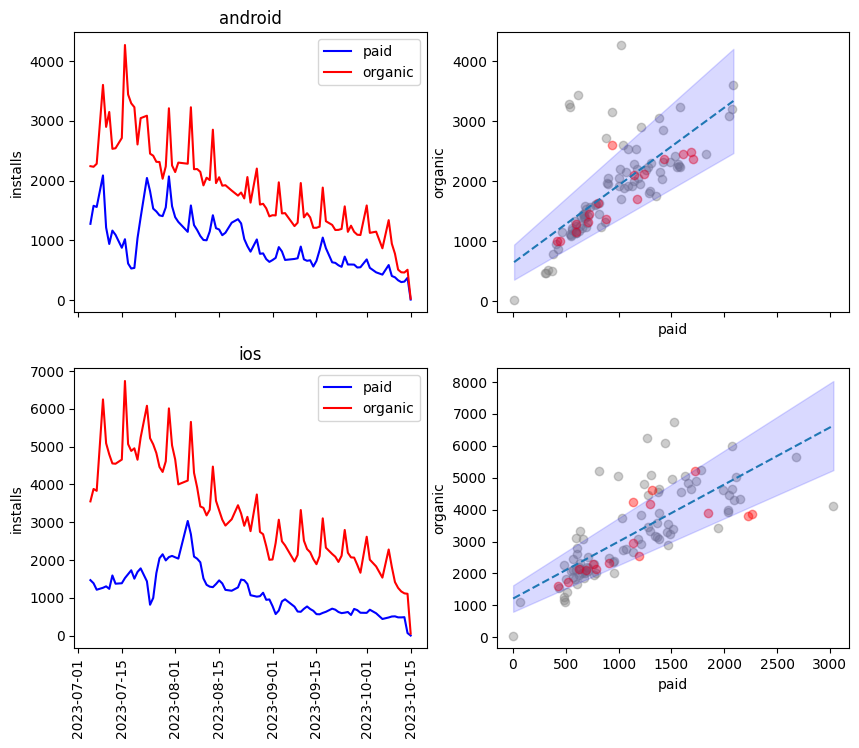

In [62]:
results = pd.DataFrame(index=platforms, columns=['Intercept', 'Coefficient', 'R2'])

_, ax = pp.subplots(nrows=len(platforms), ncols=2, sharex='col', figsize=(10, 8))
for n, platform in enumerate(platforms):
    X = X_train[platform].sort_index().astype(float)
    y = y_train[platform].sort_index().astype(float)
    
    ax[n,0].plot(X, color='blue', label='paid')
    ax[n,0].plot(y, color='red', label='organic')
    ax[n,0].set(title=platform)
    ax[n,0].legend()
    ax[n,0].tick_params(axis='x', labelrotation=90)
    ax[n,0].set_ylabel('installs')
    
    ## Fit regression line
    popt, pcov = curve_fit(
        func, 
        X, 
        y,
        p0=[0,0],
        #bounds=(0,1000)
    )
    x_ = np.linspace(X.min(), X.max())
    organic_predicted = func(x_, *popt)
    std = np.sqrt(np.diagonal(pcov))                                #standard deviation of errors on parameters
    
    lower_bound = func(x_, *(popt - 1.96*std))
    upper_bound = func(x_, *(popt + 1.96*std))

    ## plot data points
    ax[n,1].scatter(x=X, y=y, color='gray', alpha=0.4)                #train data points
    ax[n,1].scatter(x=X_test[platform], y=y_test[platform], color='red',alpha=0.4)    #test data points
    ## plot regression line
    ax[n,1].plot(x_, organic_predicted, linestyle='--')
    ax[n,1].fill_between(x_,
                         lower_bound,
                         upper_bound,
                         color='blue',
                         alpha=0.15
    )
    ax[n,1].set_xlabel('paid')
    ax[n,1].set_ylabel('organic')

    results.loc[platform, ['Intercept', 'Coefficient']] = popt
    results.loc[platform, 'R2'] = r2_score(y_test[platform].astype(float), 
                                           func(X_test[platform].astype(float), *popt)
                                    )
    
print(results)
print("""
      r: correlation coefficient saying how strong is the relation between X and y
      R2: coefficient of determination saying how much variability of y can be explained by X
      in simple linear regression, r2 = R2
      """)

In [66]:
(popt + 1.96*std)[1], (popt - 1.96*std)[1]

(2.113495399353623, 1.4652837869780826)

## Gaussian Function

In [41]:
def mean(x, y):
    return sum(x*y) / sum(y)

def sigma (x, y):
    return np.sqrt(sum(y * (x - mean(x, y))**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))


                   a            b        sigma        R2
android  2933.763103  2105.792762  1240.691902  0.683272
ios      4938.636084  2181.293703  1220.568586   0.64697


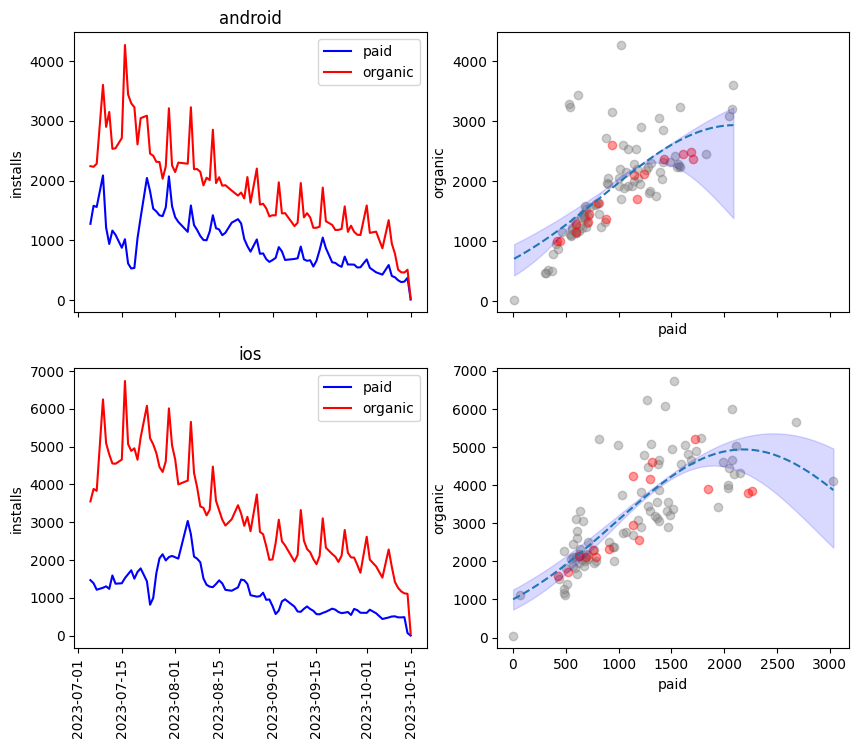

In [59]:
results_gauss = pd.DataFrame(index=platforms, columns=['a','b', 'sigma', 'R2'])

_, ax2 = pp.subplots(nrows=len(platforms), ncols=2, sharex='col', figsize=(10, 8))
for n, platform in enumerate(platforms):
    X=X_train[platform].sort_index().astype(float)
    y=y_train[platform].sort_index().astype(float)
    
    ax2[n,0].plot(X, color='blue', label='paid')
    ax2[n,0].plot(y, color='red', label='organic')
    ax2[n,0].set(title=platform)
    ax2[n,0].legend()
    ax2[n,0].tick_params(axis='x', labelrotation=90)
    ax2[n,0].set_ylabel('installs')
    

    popt,pcov = curve_fit(Gauss,
                          X, 
                          y, 
                          p0=[100, mean(X, y), sigma(X, y)]
    )
    
    x_ = np.linspace(X.min(), X.max())
    organic_predicted = Gauss(x_, *popt)
   
    std = np.sqrt(np.diagonal(pcov))                   # one standard deviation of parameters
    upper_bound = Gauss(x_, *(popt + 1.96*std))
    lower_bound = Gauss(x_, *(popt - 1.96*std))


    ## plot data points
    ax2[n,1].scatter(x=X, y=y, color='gray', alpha=0.4)
    ax2[n,1].scatter(x=X_test[platform], y=y_test[platform], color='red', alpha=0.4)

    ## plot regression line
    ax2[n,1].plot(x_, organic_predicted, linestyle='--')
    ax2[n,1].fill_between(x_,
                          lower_bound, 
                          upper_bound,
                          color = 'blue',
                          alpha = 0.15
    )
    ax2[n,1].set_xlabel('paid')
    ax2[n,1].set_ylabel('organic')

    results_gauss.loc[platform, ['a', 'b','sigma']]=popt
    results_gauss.loc[platform, 'R2'] = r2_score(y_test[platform].astype(float), Gauss(X_test[platform].astype(float), *popt))

print(results_gauss)

## Sigmoid Function

In [70]:
def sigmoid(x, A, k, x0, b):
    return A/(1+np.exp(-k*(x-x0))) + b

/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_49384/3402802406.py:2: RuntimeWarning: invalid value encountered in divide
  return A/(1+np.exp(-k*(x-x0))) + b
/Users/datnguyen/.pyenv/versions/3.11.5/envs/analytics/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/lj/9ds87q3x3q15md0t2hlkfm_h0000gn/T/ipykernel_49384/3402802406.py:2: RuntimeWarning: invalid value encountered in divide
  return A/(1+np.exp(-k*(x-x0))) + b


                     A       k   x0              b        R2
android   304921.93261   883.5  1.0 -303059.705337 -0.022754
ios      481302.265059  1057.0  1.0 -478061.980968 -0.016039


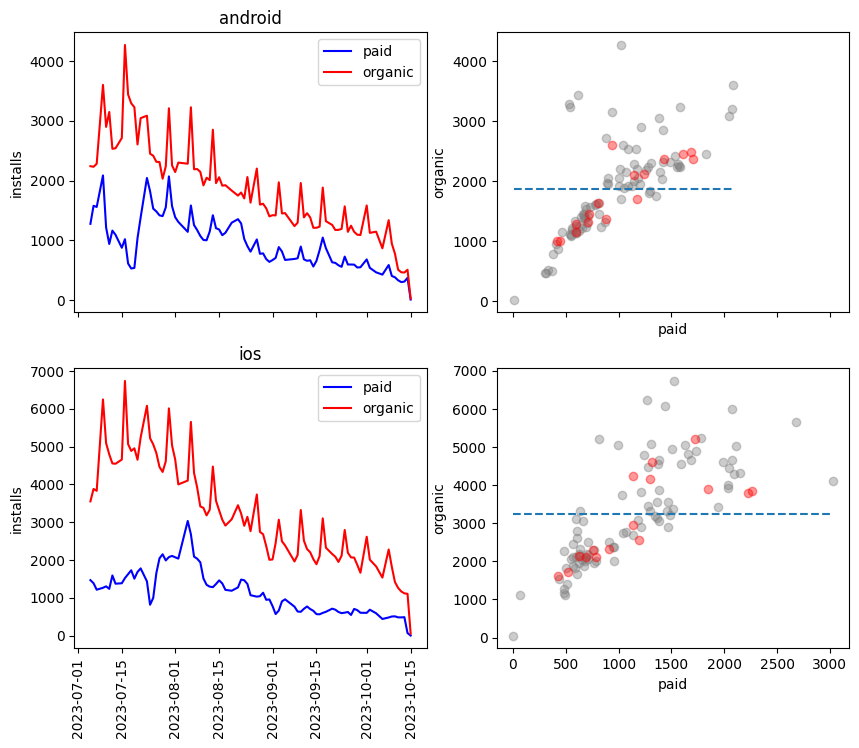

In [72]:
results_sigmoid = pd.DataFrame(index=platforms, columns=['A','k', 'x0', 'b'])

_, ax2 = pp.subplots(nrows=len(platforms), ncols=2, sharex='col', figsize=(10, 8))
for n, platform in enumerate(platforms):
    X=X_train[platform].sort_index().astype(float)
    y=y_train[platform].sort_index().astype(float)
    
    ax2[n,0].plot(X, color='blue', label='paid')
    ax2[n,0].plot(y, color='red', label='organic')
    ax2[n,0].set(title=platform)
    ax2[n,0].legend()
    ax2[n,0].tick_params(axis='x', labelrotation=90)
    ax2[n,0].set_ylabel('installs')
    

    popt,pcov = curve_fit(sigmoid,
                          X, 
                          y, 
                          p0=[max(y), np.median(X),1,min(y)]
    )
    
    x_ = np.linspace(X.min(), X.max())
    organic_predicted = sigmoid(x_, *popt)
   
    std = np.sqrt(np.diagonal(pcov))                   # one standard deviation of parameters
    upper_bound = sigmoid(x_, *(popt + 1.96*std))
    lower_bound = sigmoid(x_, *(popt - 1.96*std))


    ## plot data points
    ax2[n,1].scatter(x=X, y=y, color='gray', alpha=0.4)
    ax2[n,1].scatter(x=X_test[platform], y=y_test[platform], color='red', alpha=0.4)

    ## plot regression line
    ax2[n,1].plot(x_, organic_predicted, linestyle='--')
    ax2[n,1].fill_between(x_,
                          lower_bound, 
                          upper_bound,
                          color = 'blue',
                          alpha = 0.15
    )
    ax2[n,1].set_xlabel('paid')
    ax2[n,1].set_ylabel('organic')

    results_sigmoid.loc[platform, ['A', 'k','x0','b']]=popt
    results_sigmoid.loc[platform, 'R2'] = r2_score(y_test[platform].astype(float), sigmoid(X_test[platform].astype(float), *popt))

print(results_sigmoid)